In [32]:
import pandas as pd
import numpy as np

In [33]:
# Dataframes from Census-Data
census_column_keys = pd.read_csv("../shared_data_read_only/Census-Data/ACSST5Y2022.S2201-Column-Metadata.csv")
census_data = pd.read_csv("../shared_data_read_only/Census-Data/ACSST5Y2022.S2201-Data.csv", low_memory=False)
nonprofit_data = pd.read_csv("../shared_data_read_only/Census-Data/Nonprofit_Data_PA.csv")

In [34]:
# Dataframes from Education-Data
enrollment_demographics = pd.read_csv("../shared_data_read_only/Education-Data/2023-2024 Enrollment & Demographics.csv")
master_school_list = pd.read_csv("../shared_data_read_only/Education-Data/2023-2024 Master School List (20231003).csv")
college_matriculation = pd.read_csv("../shared_data_read_only/Education-Data/SDP_College_Matriculation_2021-2022.csv")
graduation_rates = pd.read_csv("../shared_data_read_only/Education-Data/SDP_Graduation_Rates_School_S_2023-02-15.csv")
school_metrics = pd.read_csv("../shared_data_read_only/Education-Data/SPREE_SY2122_School_Metric_Scores.csv")
student_ada = pd.read_csv("../shared_data_read_only/Education-Data/Student_ADA_Yearly.csv")

In [35]:
# Dataframes from Geography-Mapping
geography_map = pd.read_csv("../shared_data_read_only/Geography-Mapping/ZIP_TRACT_122023.csv")

In [36]:
#Clean and merge the census data

#check if NAME column contains "Pennsylvania"
PA_census_data = census_data[census_data['NAME'].str.contains('Pennsylvania')]
PA_census_data.loc[:, 'GEO_ID'] = PA_census_data['GEO_ID'].str.replace('1400000US', '')
PA_census_data = PA_census_data.rename({'GEO_ID' : 'TRACT'}, axis=1)
PA_census_data['TRACT'] = PA_census_data['TRACT'].astype(str)
PA_geography_map = geography_map[geography_map['USPS_ZIP_PREF_STATE'].str.contains('PA')]
PA_geography_map.loc[:, 'TRACT'] = PA_geography_map['TRACT'].astype(str)
merged_census_data = pd.merge(PA_census_data, PA_geography_map, on='TRACT', how='outer')
print(merged_census_data)
columns = ['ZIP'] + [col for col in merged_census_data.columns if col != 'ZIP']
merged_census_data['ZIP'] = merged_census_data['ZIP'].fillna(0).astype(int)
merged_census_data.head(5)

            TRACT                                             NAME  \
0     42001030101  Census Tract 301.01; Adams County; Pennsylvania   
1     42001030101  Census Tract 301.01; Adams County; Pennsylvania   
2     42001030101  Census Tract 301.01; Adams County; Pennsylvania   
3     42001030101  Census Tract 301.01; Adams County; Pennsylvania   
4     42001030103  Census Tract 301.03; Adams County; Pennsylvania   
...           ...                                              ...   
8903  42133024001   Census Tract 240.01; York County; Pennsylvania   
8904  42133024002   Census Tract 240.02; York County; Pennsylvania   
8905  42133024002   Census Tract 240.02; York County; Pennsylvania   
8906  42133024002   Census Tract 240.02; York County; Pennsylvania   
8907  42133024002   Census Tract 240.02; York County; Pennsylvania   

     S2201_C01_001E S2201_C01_001M S2201_C01_002E S2201_C01_002M  \
0              1061             90            451             81   
1              1061    

,TRACT,NAME,S2201_C01_001E,S2201_C01_001M,S2201_C01_002E,S2201_C01_002M,S2201_C01_003E,S2201_C01_003M,S2201_C01_004E,S2201_C01_004M,...,S2201_C06_038E,S2201_C06_038M,Unnamed: 458,ZIP,USPS_ZIP_PREF_CITY,USPS_ZIP_PREF_STATE,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,42001030101,Census Tract 301.01; Adams County; Pennsylvania,1061,90,451,81,610,99,676,75,...,55.8,8.6,NaN,17019,DILLSBURG,PA,0.006840,0.005141,0.0,0.006604
1,42001030101,Census Tract 301.01; Adams County; Pennsylvania,1061,90,451,81,610,99,676,75,...,55.8,8.6,NaN,17316,EAST BERLIN,PA,0.099727,0.054795,0.0,0.098321
2,42001030101,Census Tract 301.01; Adams County; Pennsylvania,1061,90,451,81,610,99,676,75,...,55.8,8.6,NaN,17324,GARDNERS,PA,0.016313,0.026316,0.0,0.016454
3,42001030101,Census Tract 301.01; Adams County; Pennsylvania,1061,90,451,81,610,99,676,75,...,55.8,8.6,NaN,17372,YORK SPRINGS,PA,0.406977,0.420290,0.3,0.406893
4,42001030103,Census Tract 301.03; Adams County; Pennsylvania,847,160,399,151,448,134,662,140,...,77.1,11.4,NaN,17316,EAST BERLIN,PA,0.281421,0.041096,0.1,0.275779


In [37]:
columns_to_keep = ["ZIP", "TRACT", "NAME", "S2201_C01_034E", "S2201_C01_026E", "S2201_C01_025E", "S2201_C01_028E", "RES_RATIO", "S2201_C01_032E", "S2201_C03_001E", "BUS_RATIO", "OTH_RATIO", "TOT_RATIO"]
merged_census_data = merged_census_data[columns_to_keep]
merged_census_data.rename(columns={'S2201_C01_034E': 'MEDIAN INCOME', 'S2201_C01_026E':"Black and African American", "S2201_C01_025E":"White", "S2201_C01_028E":"Asian", "S2201_C01_032E":"Hispanic or Latino", "S2201_C03_001E":"Food stamps"}, inplace=True)
merged_census_data.head(5)
print(len(merged_census_data))



8908


In [38]:
# zip codes for lowest_median_income
def convert_income(income_list):
    if not income_list or income_list[0] == '-':
        return 0
    return income_list[0]
merged_census_copy = merged_census_data.sort_values(by='MEDIAN INCOME',ascending=True)
merged_census_copy['MEDIAN INCOME'] = merged_census_copy['MEDIAN INCOME'].apply(convert_income)
# print(['MEDIAN INCOME'].dtype)
merged_census_copy = merged_census_copy[merged_census_copy['MEDIAN INCOME'] != 0]
merged_census_copy.head(10)

,ZIP,TRACT,NAME,MEDIAN INCOME,Black and African American,White,Asian,RES_RATIO,Hispanic or Latino,Food stamps,BUS_RATIO,OTH_RATIO,TOT_RATIO
8073,15347,42125742102,Census Tract 7421.02; Washington County; Penns...,1,0,690,0,0.000000,0,57,0.000000,1.000000,1.000000
8072,15301,42125742102,Census Tract 7421.02; Washington County; Penns...,1,0,690,0,0.027954,0,57,0.008481,0.001959,0.025252
7252,19136,42101034702,Census Tract 347.02; Philadelphia County; Penn...,1,171,1020,78,0.074308,86,76,0.020346,0.000000,0.068131
7253,19152,42101034702,Census Tract 347.02; Philadelphia County; Penn...,1,171,1020,78,0.035070,86,76,0.028289,0.032520,0.034678
2655,19320,42029307200,Census Tract 3072; Chester County; Pennsylvania,1,12,376,0,0.008972,15,29,0.004032,0.001550,0.008571
2657,19365,42029307200,Census Tract 3072; Chester County; Pennsylvania,1,12,376,0,0.081306,15,29,0.012000,0.044944,0.075368
2656,19330,42029307200,Census Tract 3072; Chester County; Pennsylvania,1,12,376,0,0.038079,15,29,0.030769,0.009259,0.036634
2654,19310,42029307200,Census Tract 3072; Chester County; Pennsylvania,1,12,376,0,0.019567,15,29,0.088235,0.037037,0.022287
8800,17329,42133022404,Census Tract 224.04; York County; Pennsylvania,1,33,2004,0,0.052381,0,46,0.000000,0.000000,0.051450
8801,17331,42133022404,Census Tract 224.04; York County; Pennsylvania,1,33,2004,0,0.085895,0,46,0.017451,0.003947,0.079039


In [39]:
merged_census_copy = merged_census_copy.sort_values(by='MEDIAN INCOME', ascending=True)
less_income_zip_codes = merged_census_copy['ZIP'].head(20).to_numpy()
less_income_zip_codes = set(less_income_zip_codes)
print(less_income_zip_codes)
print(len(merged_census_data))

{19073, 15238, 15239, 15240, 19462, 19086, 19352, 17055, 16802, 16803, 19363, 15668, 19008, 19146, 15317, 15068, 15215, 15347, 19063}
8908


In [28]:
merged_census_copy = merged_census_data.sort_values(by='Food stamps', ascending=False)
more_food_stamps_zip_codes = merged_census_copy['ZIP'].head(20).to_numpy()
more_food_stamps_zip_codes = set(more_food_stamps_zip_codes)
print(more_food_stamps_zip_codes)

{17408, 16131, 16134, 17543, 17545, 15001, 17049, 19104, 17313, 17059, 17076, 17086, 17104, 17111, 17113, 17122, 16117, 17014, 17403, 17404}


In [29]:
merged_census_copy = merged_census_data.sort_values(by='Black and African American', ascending=False)
more_black_american_zip_codes = merged_census_copy['ZIP'].head(20).to_numpy()
more_black_american_zip_codes = set(more_black_american_zip_codes)
print(more_black_american_zip_codes)

{19090, 15644, 19104, 17313, 19111, 19120, 19001, 19138, 19142, 19144, 17356, 19406, 19025, 19034, 15208, 15218, 15221, 19446, 18042, 17403}


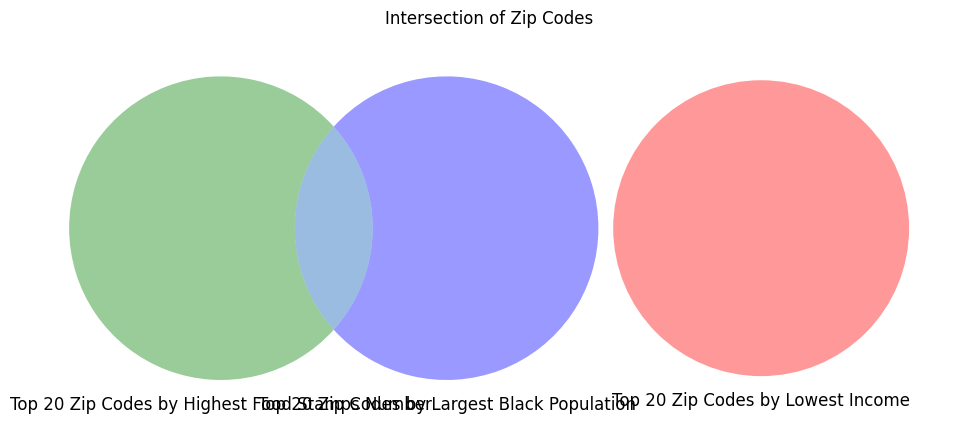

In [30]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Convert your lists or arrays to sets if they are not already sets
set1 = set(less_income_zip_codes)
set2 = set(more_food_stamps_zip_codes)
set3 = set(more_black_american_zip_codes)

# Create a Venn diagram
plt.figure(figsize=(12, 12))  # Adjust the figure size as necessary
venn = venn3([set1, set2, set3], 
             ('Top 20 Zip Codes by Lowest Income', 'Top 20 Zip Codes by Highest Food Stamps Number', 'Top 20 Zip Codes by Largest Black Population'))

# Get all subsets of the Venn diagram (indices for 3-set Venn diagrams: '100', '010', '001', '110', '101', '011', '111')
subsets = ['100', '010', '001', '110', '101', '011', '111']

# Loop through all subsets and update the labels to show actual elements from the sets
for subset in subsets:
    idx = venn.get_label_by_id(subset)
    if idx:  # Check if the subset exists in the diagram
        # Evaluate to get the elements specific to this subset
        elements = eval('&'.join([
            ('set1' if num == '1' else 'set1.symmetric_difference(set1)') if index == '1' else
            ('set2' if num == '1' else 'set2.symmetric_difference(set2)') if index == '2' else
            ('set3' if num == '1' else 'set3.symmetric_difference(set3)')
            for index, num in zip('123', subset)
        ]))

        # Set the label to these elements, joining by newline for better readability
        idx.set_text('\n'.join(map(str, elements)))

plt.title("Intersection of Zip Codes")
plt.show()

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

# Filter rows for ZIP codes 19140 - A and 19104 - B
zip_A = '19140'
zip_B = '19104'

# Filter rows for the ZIP codes
rowA_df = merged_census_data[merged_census_data['ZIP'] == zip_A]
rowB_df = merged_census_data[merged_census_data['ZIP'] == zip_B]

if not rowA_df.empty and not rowB_df.empty:
    # Extract values excluding ZIP
    rowA = rowA_df.iloc[0, 1:].values.astype(float)
    rowB = rowB_df.iloc[0, 1:].values.astype(float)

    # Normalize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(merged_census_data.iloc[:, 1:])  # Exclude ZIP for scaling
    rowA_scaled = scaled_data[df.index[merged_census_data['ZIP'] == zip_A][0]]
    rowB_scaled = scaled_data[df.index[merged_census_data['ZIP'] == zip_B][0]]

    # Calculate Euclidean distance
    euclidean_dist = euclidean(rowA_scaled, rowB_scaled)

    # Calculate Cosine Similarity
    cosine_sim = cosine_similarity([rowA_scaled], [rowB_scaled])[0][0]

    # Calculate Pearson Correlation
    pearson_corr, _ = pearsonr(rowA_scaled, rowB_scaled)

    # Display the results
    print(f"Euclidean Distance between ZIP {zip_A} and {zip_B}: {euclidean_dist}")
    print(f"Cosine Similarity between ZIP {zip_A} and {zip_B}: {cosine_sim}")
    print(f"Pearson Correlation between ZIP {zip_A} and {zip_B}: {pearson_corr}")
else:
    print("One or both ZIP codes not found in the dataset. Please check the ZIP codes and try again.")

One or both ZIP codes not found in the dataset. Please check the ZIP codes and try again.


In [53]:
merged_census_data.to_json('EDUCATION.json')

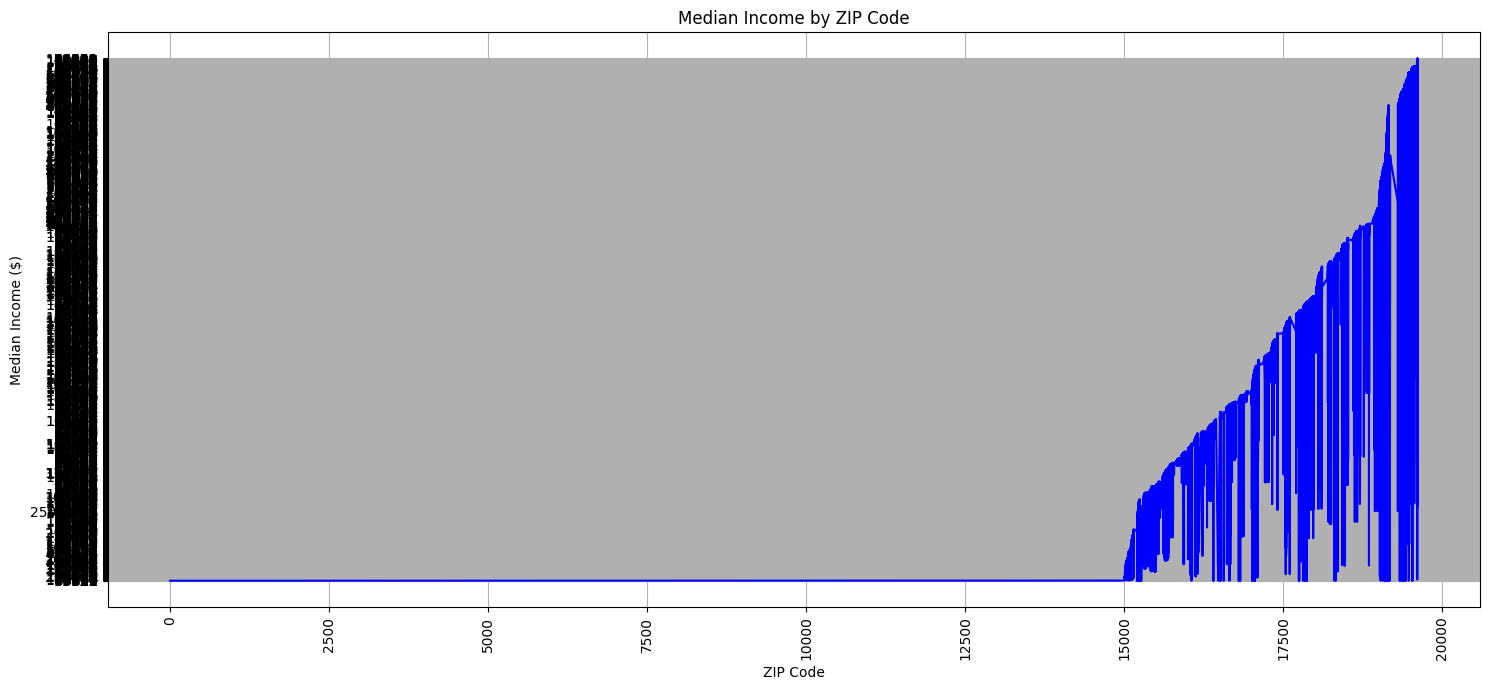

In [16]:
# merged_census_data = merged_census_data.sort_values('ZIP')

# # Plotting
# plt.figure(figsize=(10, 5))  # Set the figure size (optional)
# plt.plot(merged_census_data['ZIP'], merged_census_data['MEDIAN INCOME'], marker='o')  # Line graph with markers

# # Adding titles and labels
# plt.title('Median Income by ZIP Code')
# plt.xlabel('ZIP Code')
# plt.ylabel('Median Income ($)')

# # Displaying the grid
# plt.grid(True)

# # Show the plot
# plt.show()

import matplotlib.pyplot as plt

# Assuming merged_census_data is already sorted and loaded
plt.figure(figsize=(15, 7))
plt.plot(merged_census_data['ZIP'], merged_census_data['MEDIAN INCOME'], linestyle='-', marker='', color='b')  # Only line

plt.title('Median Income by ZIP Code')
plt.xlabel('ZIP Code')
plt.ylabel('Median Income ($)')
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

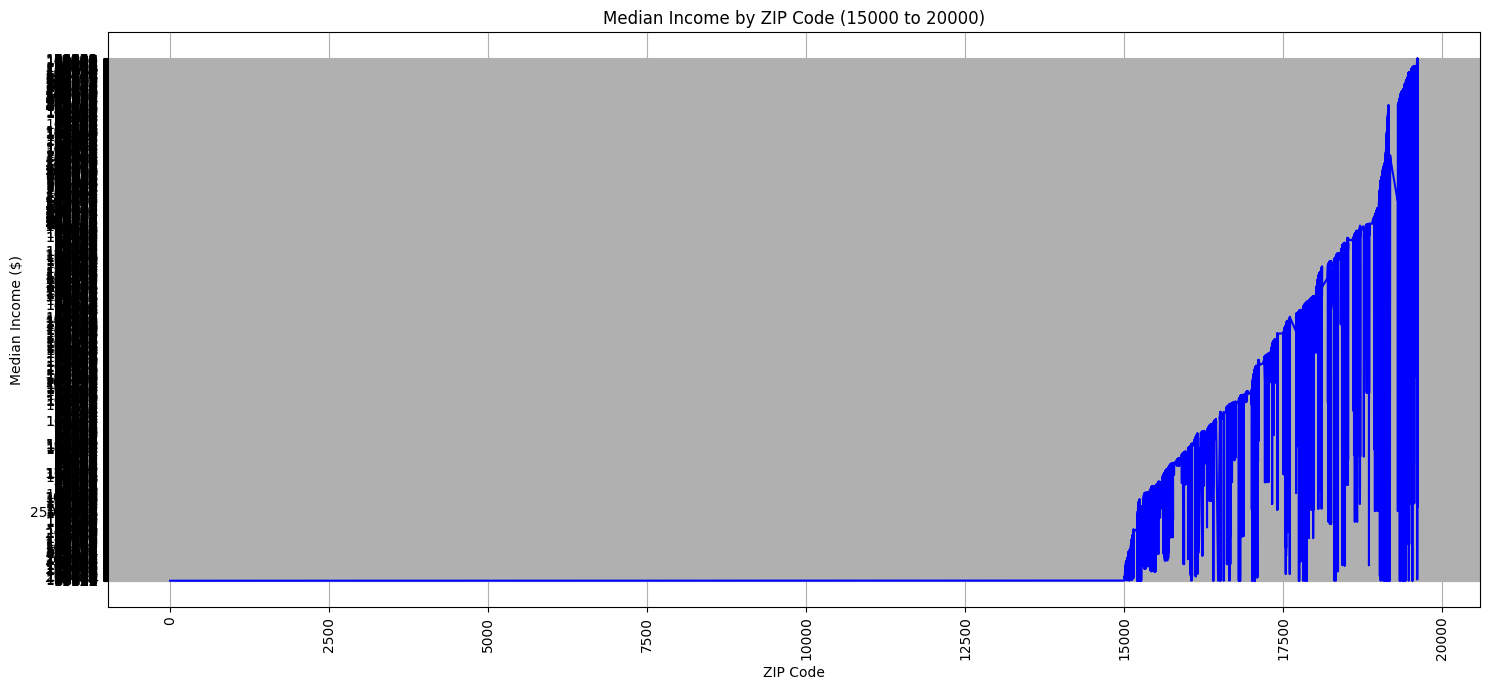

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter the DataFrame to include only ZIP codes from 15000 to 20000
filtered_data = merged_census_data[(merged_census_data['ZIP'] >= 15000) & (merged_census_data['ZIP'] <= 20000)]

# Plotting
plt.figure(figsize=(15, 7))  # Larger figure size for better visibility
plt.plot(merged_census_data['ZIP'], merged_census_data['MEDIAN INCOME'], linestyle='-', marker='', color='b')  # Only line

plt.title('Median Income by ZIP Code (15000 to 20000)')
plt.xlabel('ZIP Code')
plt.ylabel('Median Income ($)')
plt.grid(True)
plt.xticks(rotation=90) 
plt.tight_layout()  
plt.show()